### This notebook is used to generate results for the pairwise consistency benchmarking 

In [4]:
## import statements
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

In [5]:
## Read in pairwise consistency results 

dir_path="/private/groups/patenlab/mira/centrolign/analysis/pairwise_consistency/"

# All matching files
files = glob.glob(os.path.join(dir_path,
    "HPRC_r2_QCv2_chr*_pairwise_consistency.txt"))

# Read all TSVs
df_list = []
for f in files:
    
    # Skip empty files
    if os.path.getsize(f) == 0:
        continue

    df = pd.read_csv(f, sep="\t")
    
    # extract chromosome name from filename
    base = os.path.basename(f)
    chr_name = base.split("_")[3]
    df["chr"] = chr_name  # optional: track which file each row came from
    df_list.append(df)

# combined to a single df
df=pd.concat(df_list, ignore_index=True)

df.head()

,sample1,sample2,intersection,union,aligned_intersection,aligned_union,jaccard,aligned_jaccard,num_pos_ind,num_pos_dir,chr
0,HG00097.1,HG00099.2,3747091,5051067,279734,819594,0.741841,0.341308,4545319,4252839,chr16
1,HG00097.1,HG00128.2,4605794,6434286,417342,1148036,0.715821,0.363527,5728223,5311857,chr16
2,HG00097.1,HG00133.1,4003267,5901190,768940,1557755,0.678383,0.493621,5115783,4788674,chr16
3,HG00097.1,HG00133.2,4082018,5006437,193584,555179,0.815354,0.348688,4661015,4427440,chr16
4,HG00146.1,HG00097.1,4638337,5635312,88121,483712,0.823084,0.182177,5220894,5052755,chr16


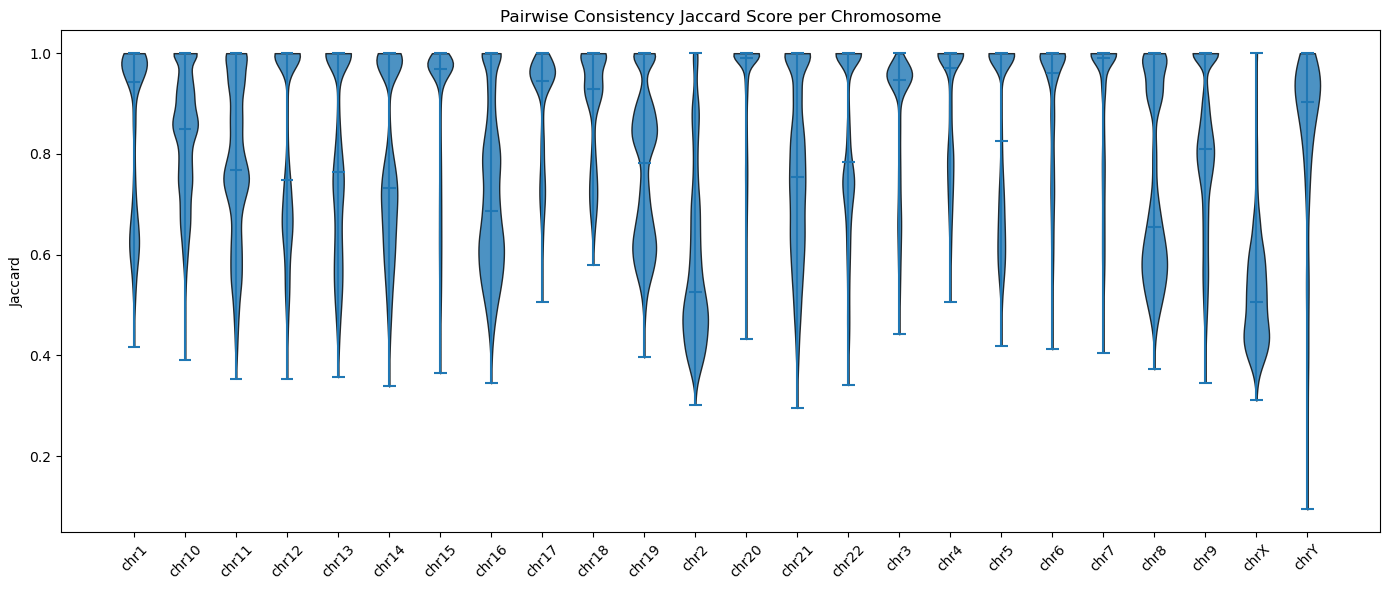

In [6]:
import matplotlib.pyplot as plt

# group your dataframe by chromosome
groups = [df[df["chr"] == c]["jaccard"].values
          for c in sorted(df["chr"].unique())]

chromosomes = sorted(df["chr"].unique())

plt.figure(figsize=(14, 6))

# make the violin plot
parts = plt.violinplot(groups, showmeans=False, showextrema=True, showmedians=True)

# prettier styling (optional)
for pc in parts['bodies']:
    pc.set_facecolor('#1f77b4')
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)

plt.xticks(range(1, len(chromosomes) + 1), chromosomes, rotation=45)
plt.ylabel("Jaccard")
plt.title("Pairwise Consistency Jaccard Score per Chromosome")
plt.tight_layout()
plt.show()


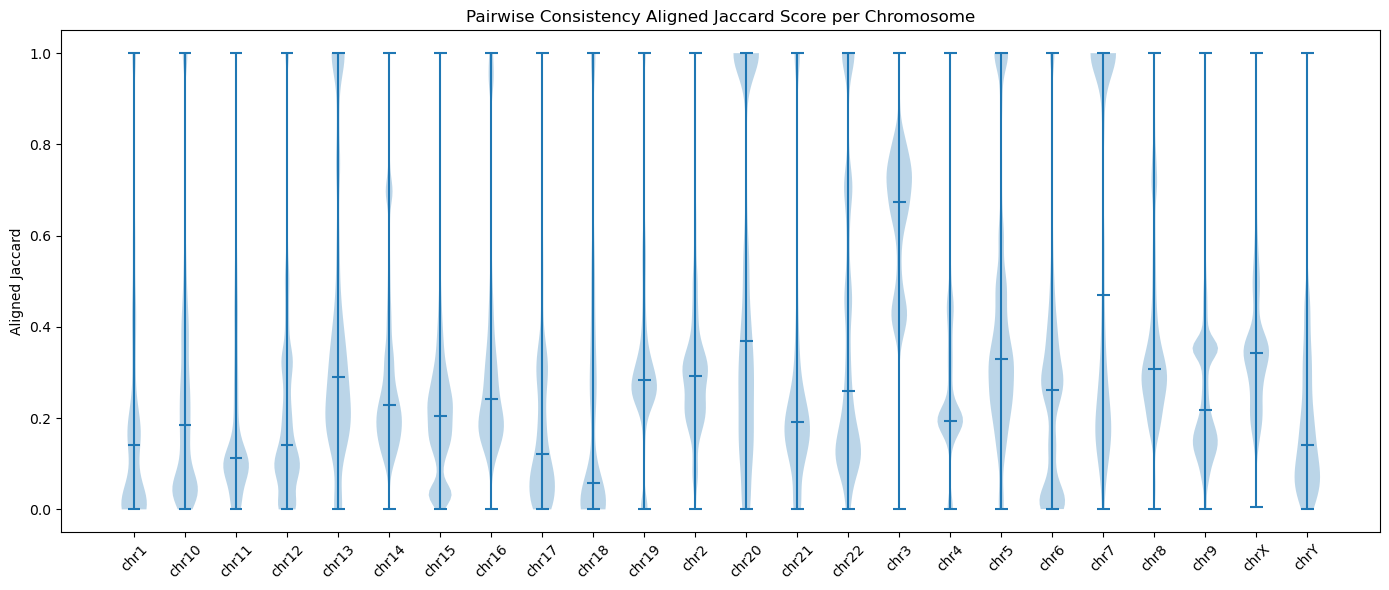

In [4]:
import matplotlib.pyplot as plt

# group your dataframe by chromosome
groups = [df[df["chr"] == c]["aligned_jaccard"].values
          for c in sorted(df["chr"].unique())]

# Drop NAs
groups = [df[df["chr"] == c]["aligned_jaccard"].dropna().values
          for c in chromosomes]

chromosomes = sorted(df["chr"].unique())

plt.figure(figsize=(14, 6))

# make the violin plot
parts = plt.violinplot(groups, showmeans=False, showextrema=True, showmedians=True)

plt.xticks(range(1, len(chromosomes) + 1), chromosomes, rotation=45)
plt.ylabel("Aligned Jaccard")
plt.title("Pairwise Consistency Aligned Jaccard Score per Chromosome")
plt.tight_layout()
plt.show()

In [7]:
# Read in pairwise distance values to the dataframe 
# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df_chr = pd.read_csv(f, header=None, names=['sample1', 'sample2', 'pairwise_dist'])
    df_chr["chr"] = chr_val

    all_dfs.append(df_chr)

# Combine into one dataframe
dist_df = pd.concat(all_dfs, ignore_index=True)

## Combine pairwise dists and SVs into single dataframe 
# Sort sample pairs so ordering doesn't matter
df_dist_sorted = dist_df.copy()
df_dist_sorted[['sample1', 'sample2']] = np.sort(df_dist_sorted[['sample1', 'sample2']], axis=1)

df_pairwise_consis = df.copy()
df_pairwise_consis[['sample1', 'sample2']] = np.sort(df_pairwise_consis[['sample1', 'sample2']], axis=1)

# Merge on sample1, sample2, AND chr
df = df_pairwise_consis.merge(df_dist_sorted, on=['sample1', 'sample2', 'chr'], how='left')

df.head()

,sample1,sample2,intersection,union,aligned_intersection,aligned_union,jaccard,aligned_jaccard,num_pos_ind,num_pos_dir,chr,pairwise_dist
0,HG00097.1,HG00099.2,3747091,5051067,279734,819594,0.741841,0.341308,4545319,4252839,chr16,0.719148
1,HG00097.1,HG00128.2,4605794,6434286,417342,1148036,0.715821,0.363527,5728223,5311857,chr16,0.685886
2,HG00097.1,HG00133.1,4003267,5901190,768940,1557755,0.678383,0.493621,5115783,4788674,chr16,0.566376
3,HG00097.1,HG00133.2,4082018,5006437,193584,555179,0.815354,0.348688,4661015,4427440,chr16,0.800669
4,HG00097.1,HG00146.1,4638337,5635312,88121,483712,0.823084,0.182177,5220894,5052755,chr16,0.863991


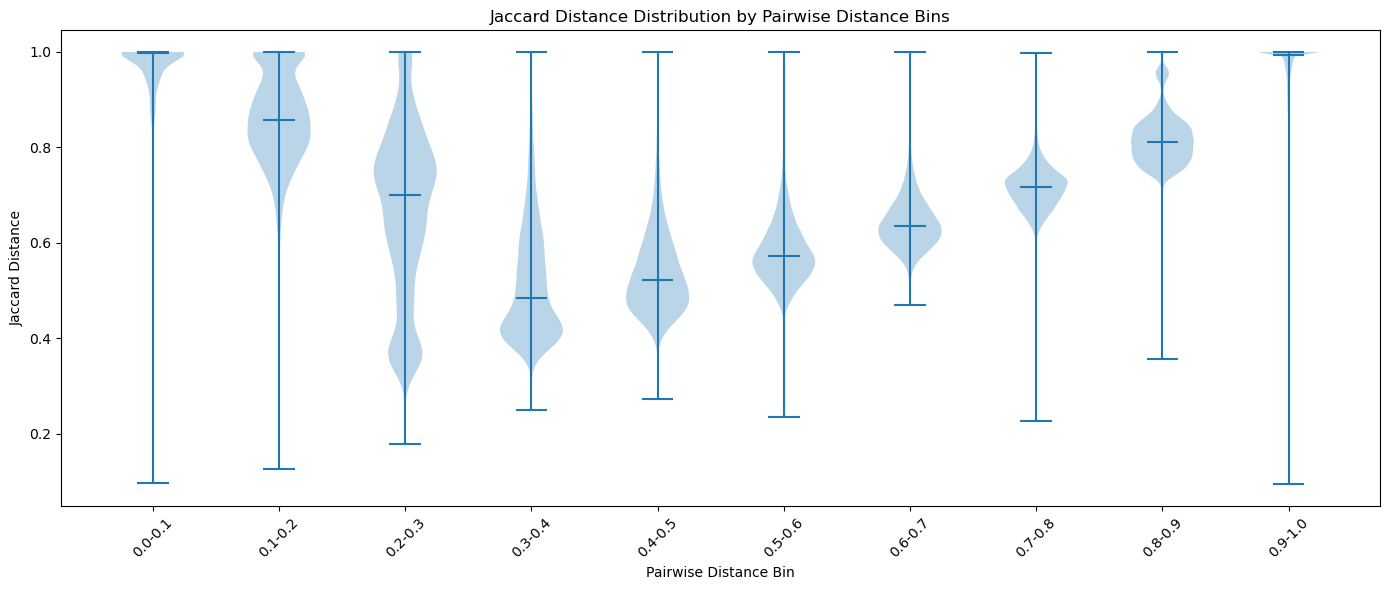

In [18]:
# Across all chromosomes, plot the distribution of pairwise consistency within each bin 

# define bins and labels
bins = np.arange(0, 1.1, 0.1)       # 0.0, 0.1, 0.2, ... 1.0
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]

df["dist_bin"] = pd.cut(df["pairwise_dist"], bins=bins, labels=labels, include_lowest=True)

# remove NAs
groups = [
    df.loc[df["dist_bin"] == label, "jaccard"].dropna().values
    for label in labels
]

plt.figure(figsize=(14, 6))

plt.violinplot(groups, showmeans=False, showmedians=True, showextrema=True)

plt.xticks(range(1, len(labels) + 1), labels, rotation=45)
plt.ylabel("Jaccard Distance")
plt.xlabel("Pairwise Distance Bin")
plt.title("Jaccard Distance Distribution by Pairwise Distance Bins")

plt.tight_layout()
plt.show()

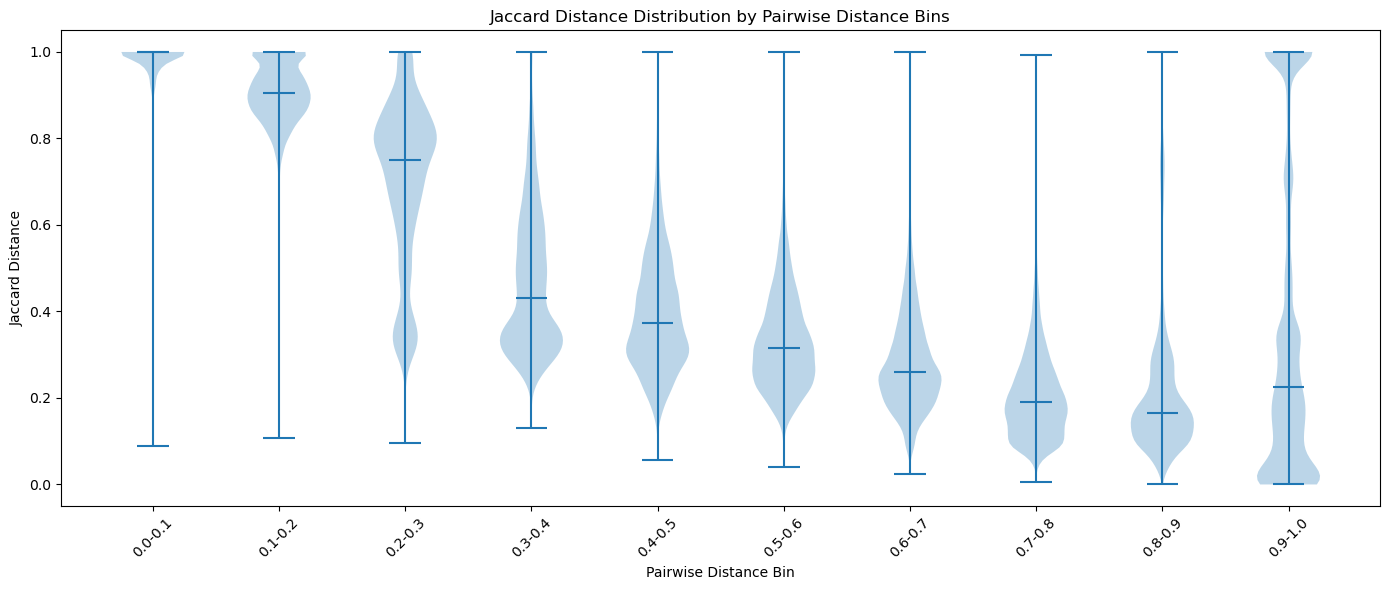

In [19]:
# Across all chromosomes, plot the distribution of pairwise consistency within each bin 

# define bins and labels
bins = np.arange(0, 1.1, 0.1)       # 0.0, 0.1, 0.2, ... 1.0
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]

df["dist_bin"] = pd.cut(df["pairwise_dist"], bins=bins, labels=labels, include_lowest=True)

# remove NAs
groups = [
    df.loc[df["dist_bin"] == label, "aligned_jaccard"].dropna().values
    for label in labels
]

plt.figure(figsize=(14, 6))

plt.violinplot(groups, showmeans=False, showmedians=True, showextrema=True)

plt.xticks(range(1, len(labels) + 1), labels, rotation=45)
plt.ylabel("Jaccard Distance")
plt.xlabel("Pairwise Distance Bin")
plt.title("Jaccard Distance Distribution by Pairwise Distance Bins")

plt.tight_layout()
plt.show()

In [ ]:
# Pull out a few examples for synteny plots
subset = df[
    (df["chr"] == "chr6") &
    (df["dist_bin"] == "0.3-0.4") &
    (df["jaccard"] < 0.6)
]

print(subset.head())


          sample1    sample2  intersection    union  aligned_intersection  \
219392  HG00253.1  HG02486.2       2850824  5266379               1502860   
224299  HG00741.2  NA19700.1       2575868  4517177               1559079   
225834  HG01167.2  NA19700.1       2587632  4559339               1527548   
225836  HG01167.2  NA19835.1       2634827  4426107               1598283   
226183  HG01258.1  HG02083.2       2067307  4379079                509035   

        aligned_union   jaccard  aligned_jaccard  num_pos_ind  num_pos_dir  \
219392        2527347  0.541325         0.594639      4016714      4100489   
224299        2429578  0.570238         0.641708      3490176      3602869   
225834        2394617  0.567545         0.637909      3490176      3656795   
225836        2385599  0.595292         0.669971      3465449      3595485   
226183        1396515  0.472087         0.364504      3545250      2901136   

         chr  pairwise_dist dist_bin  
219392  chr6       0.350409  

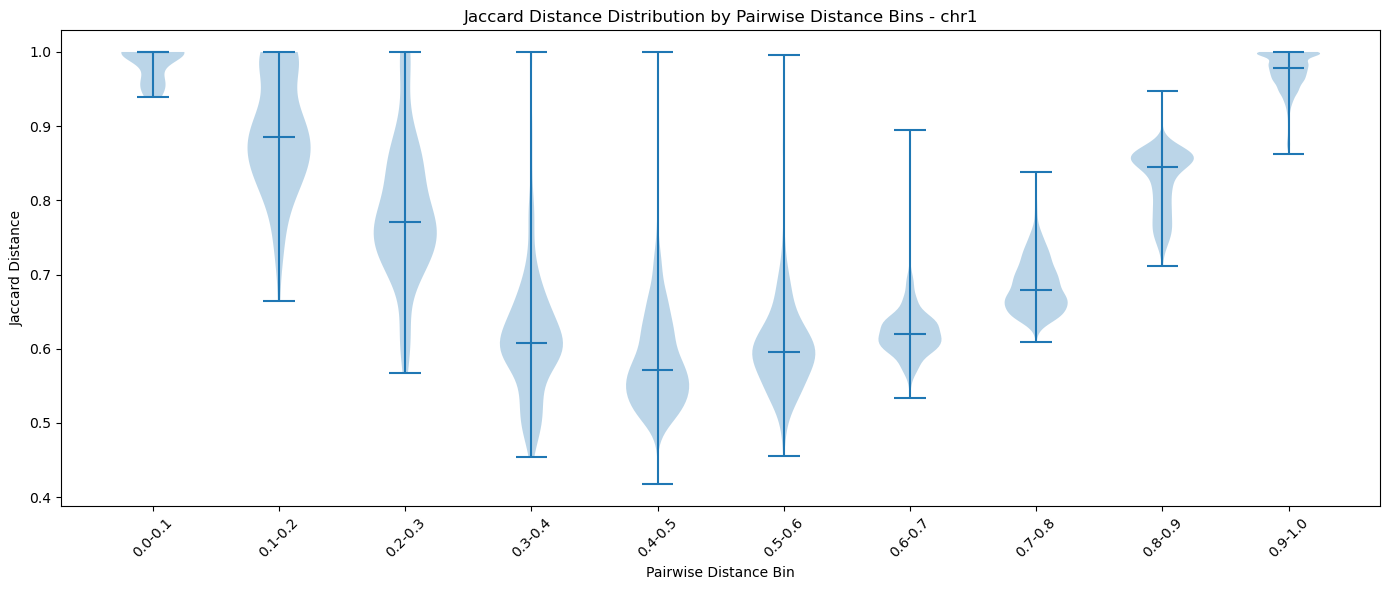

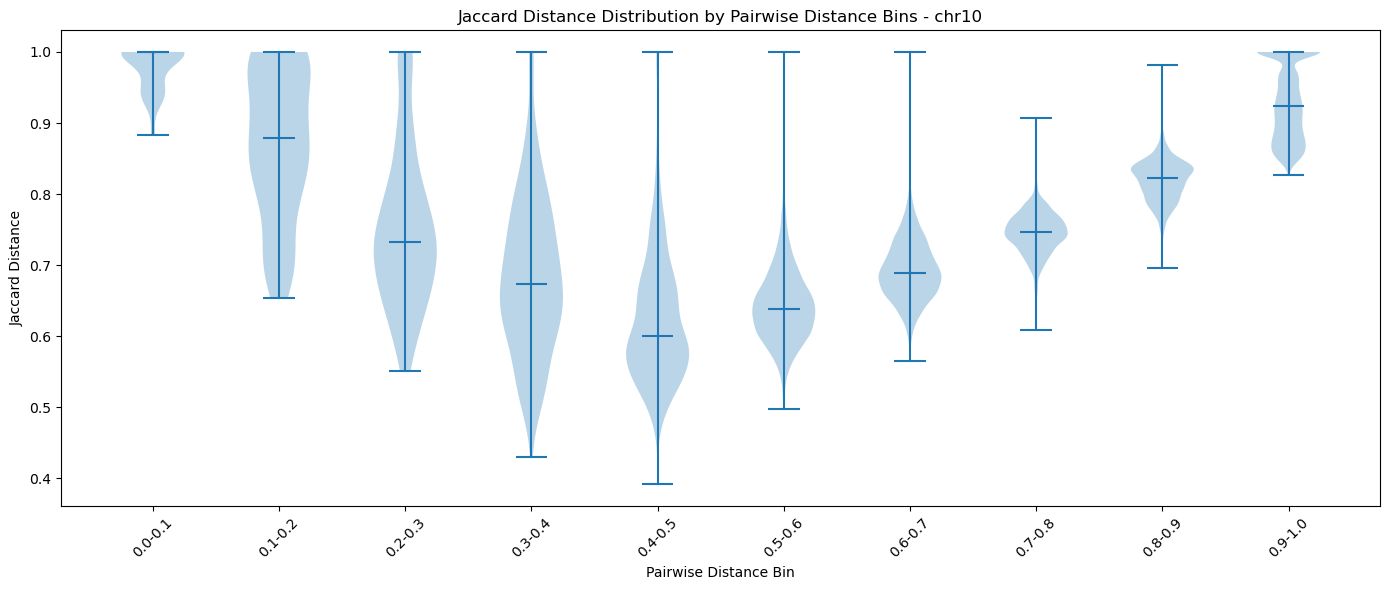

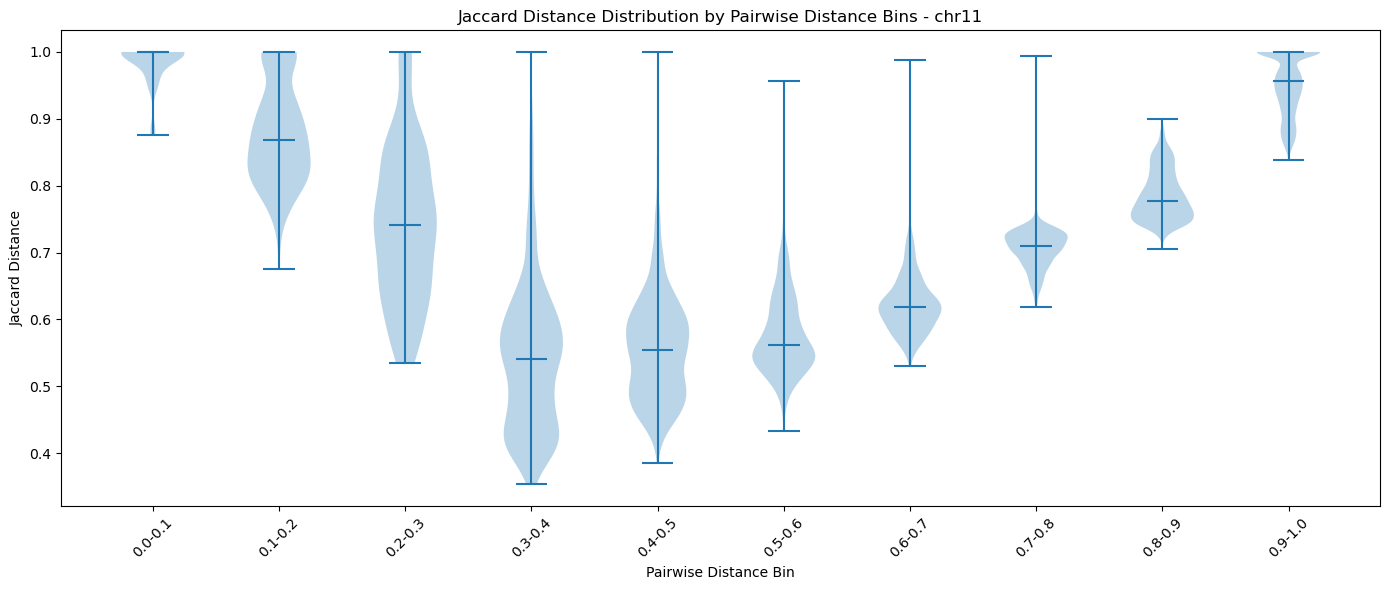

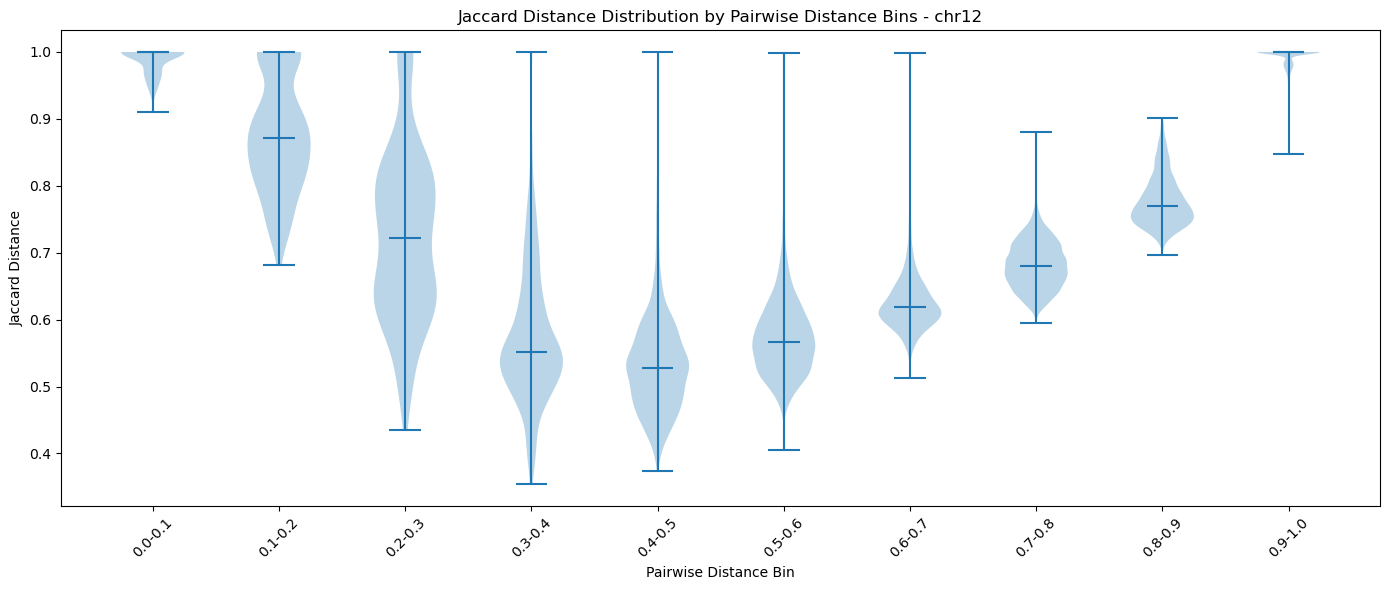

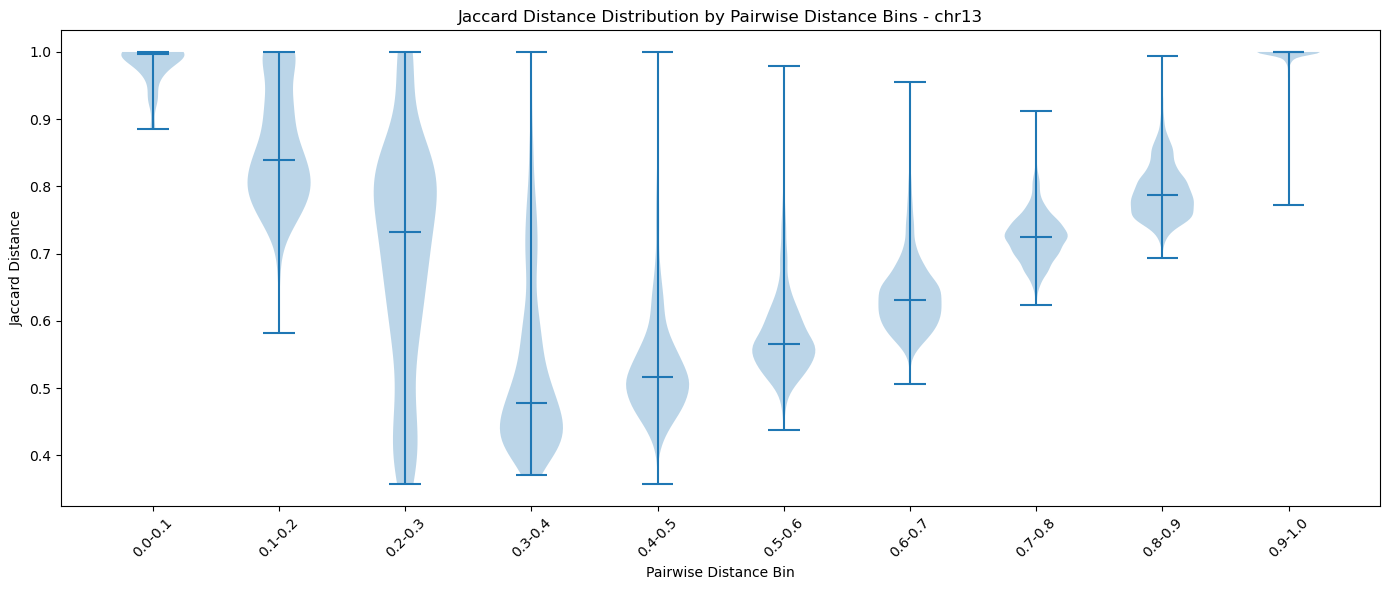

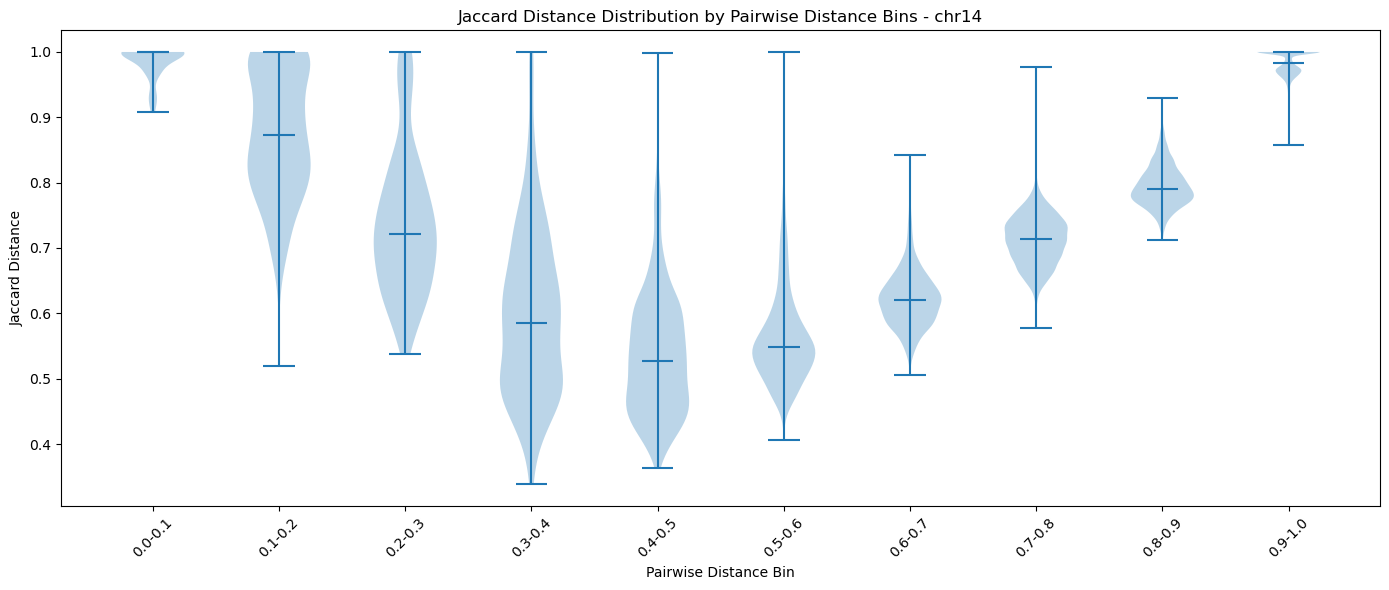

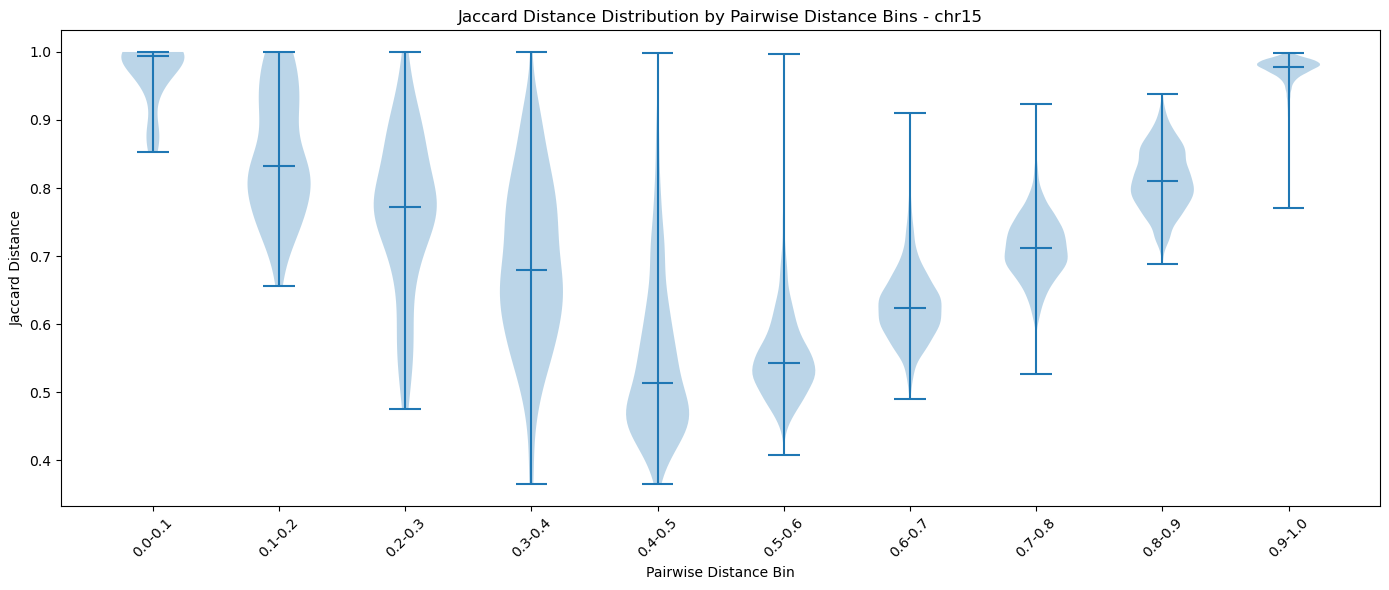

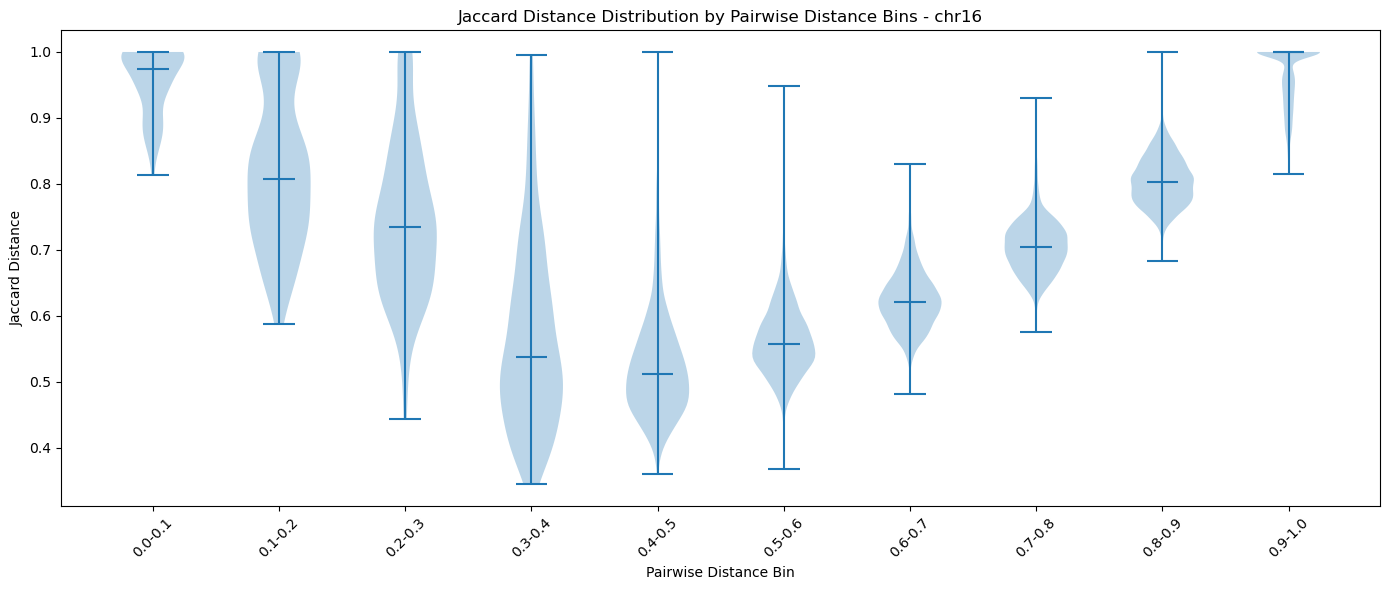

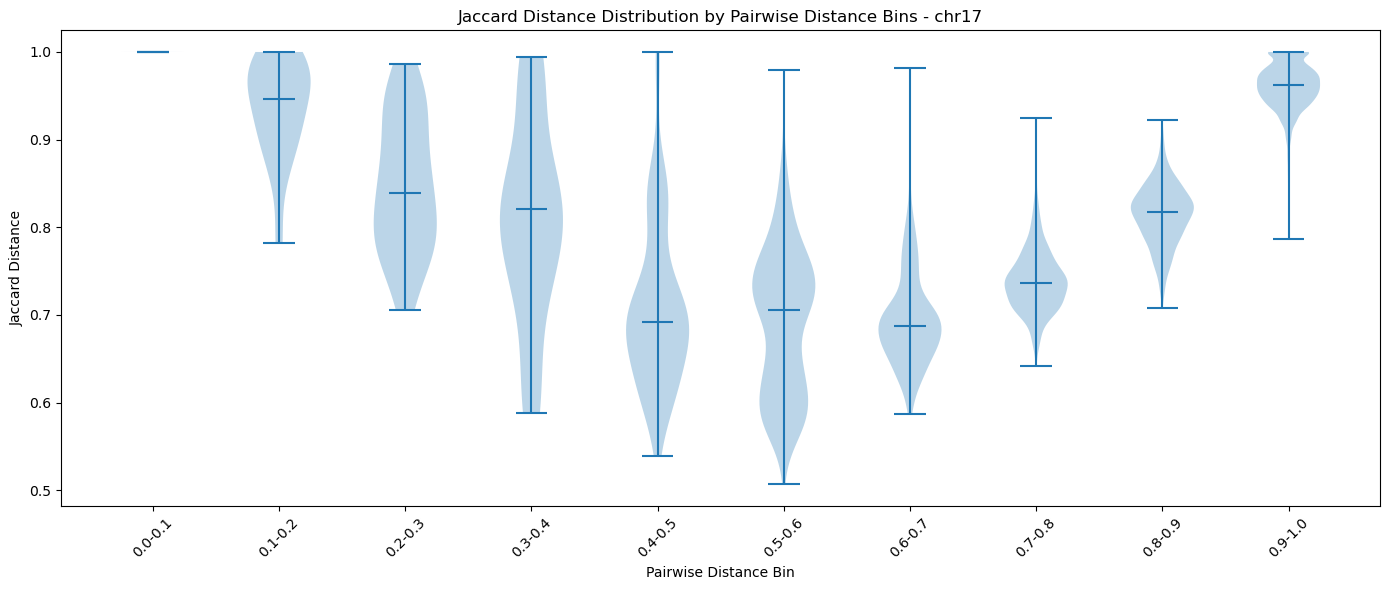

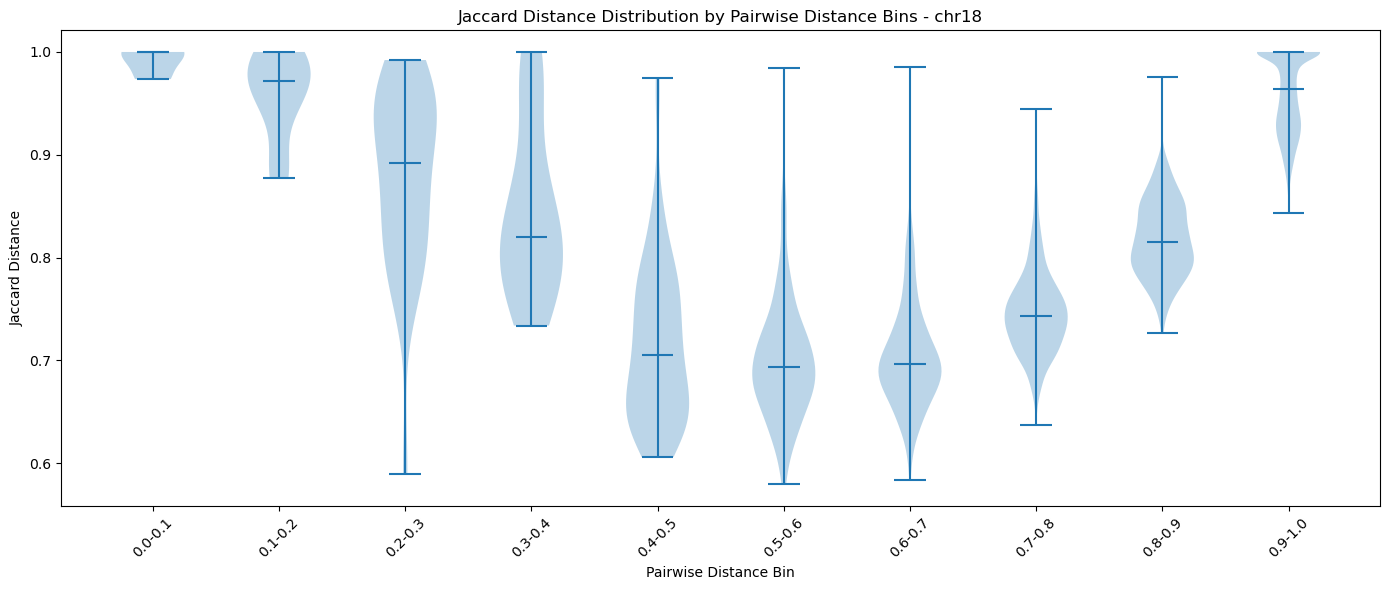

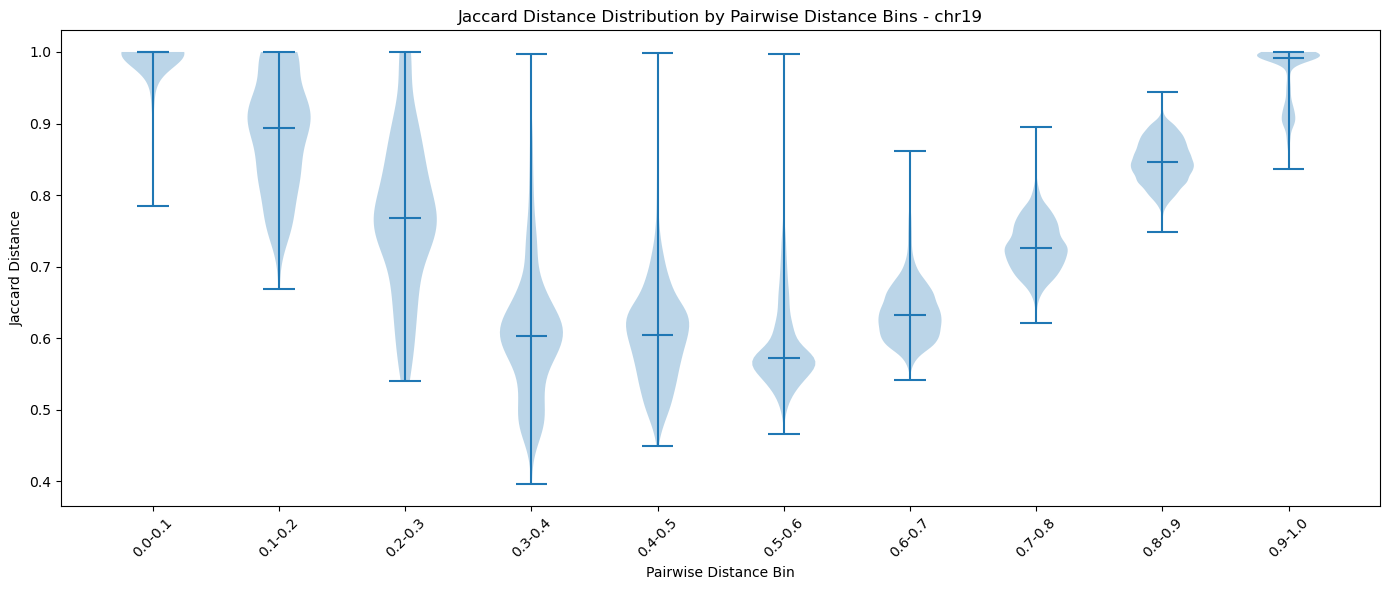

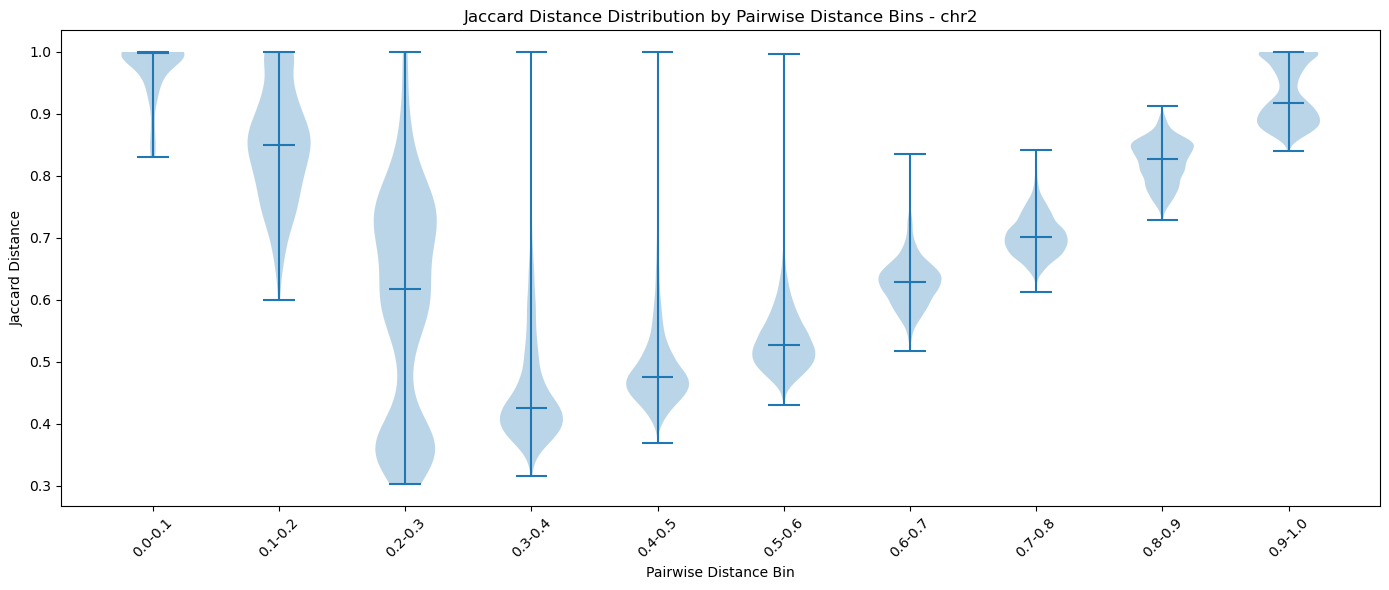

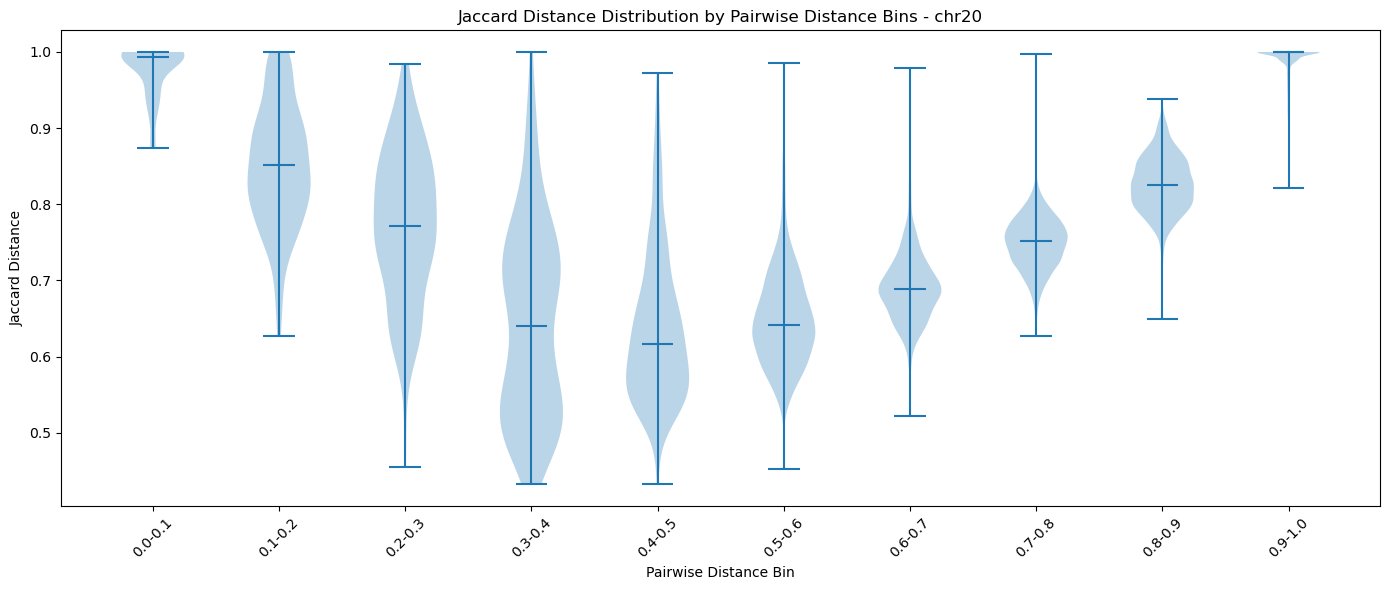

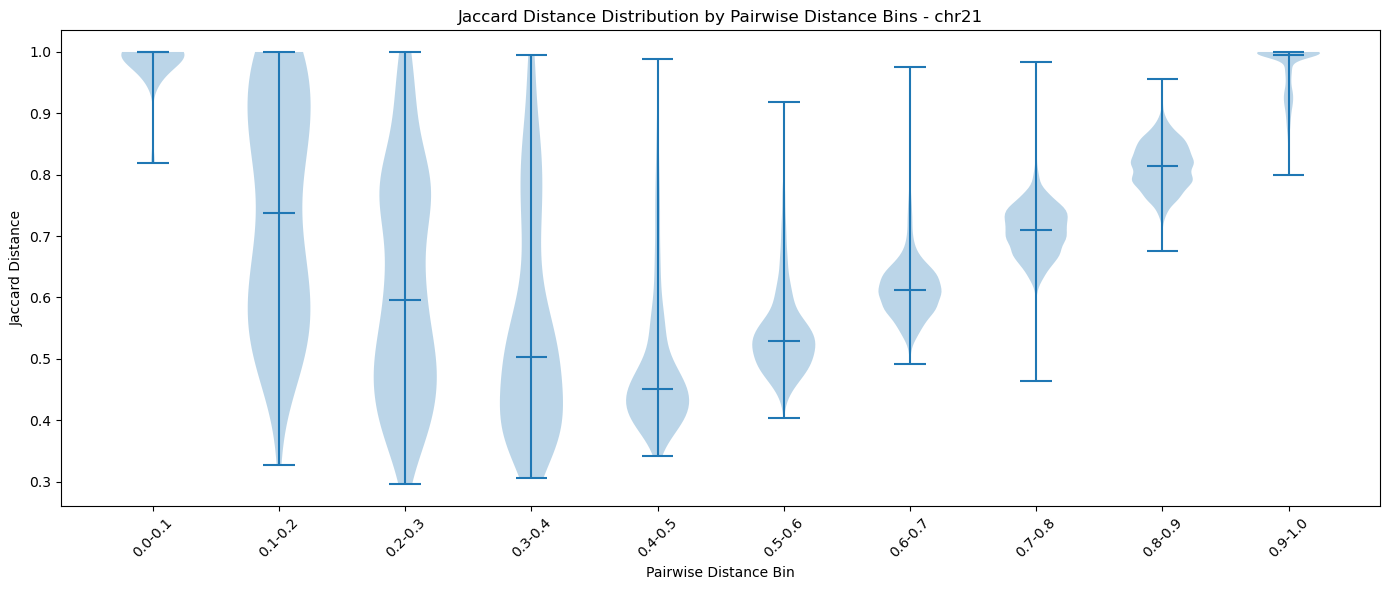

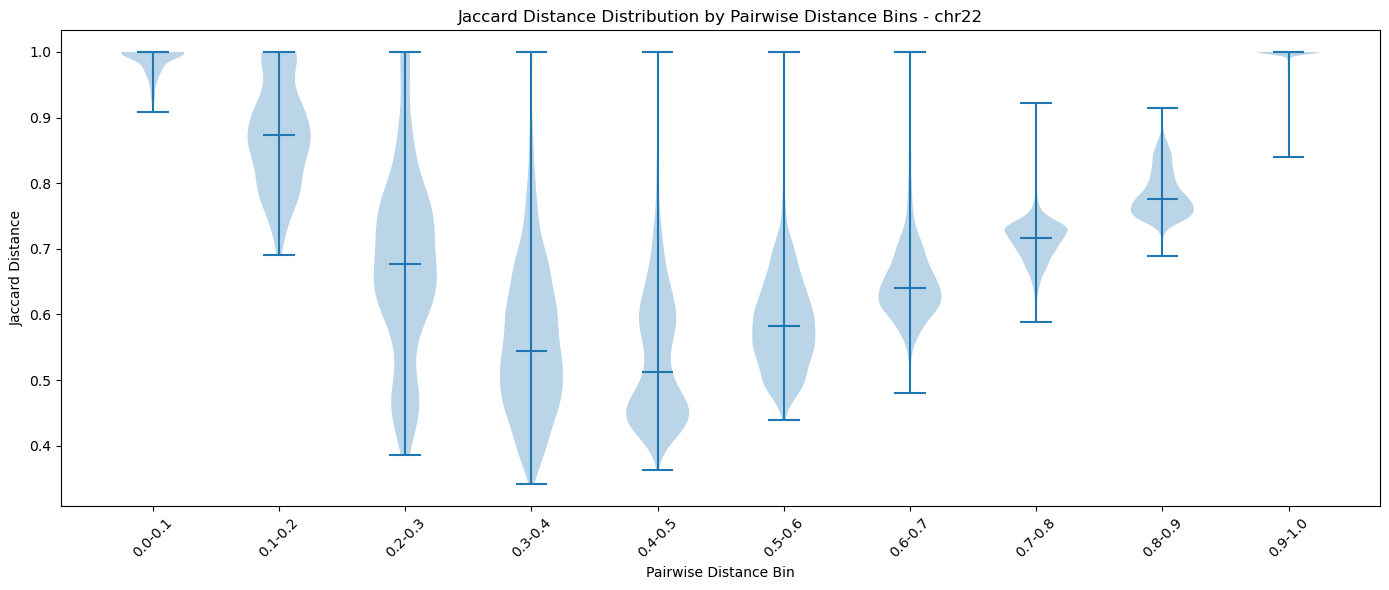

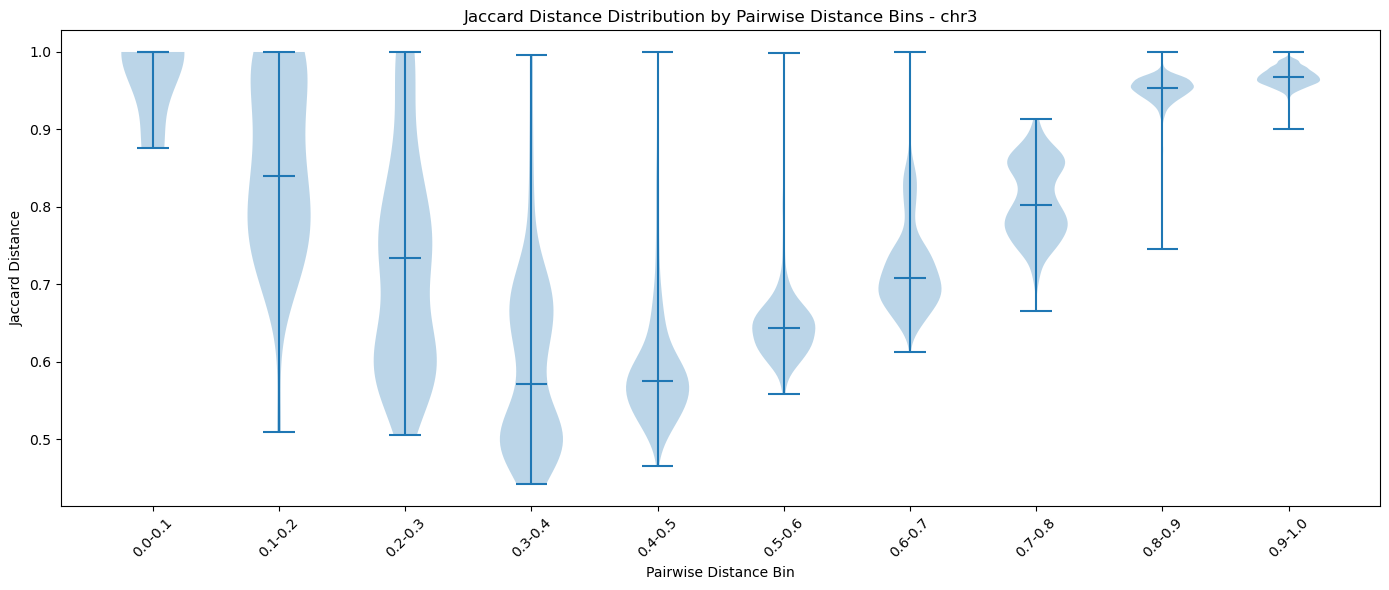

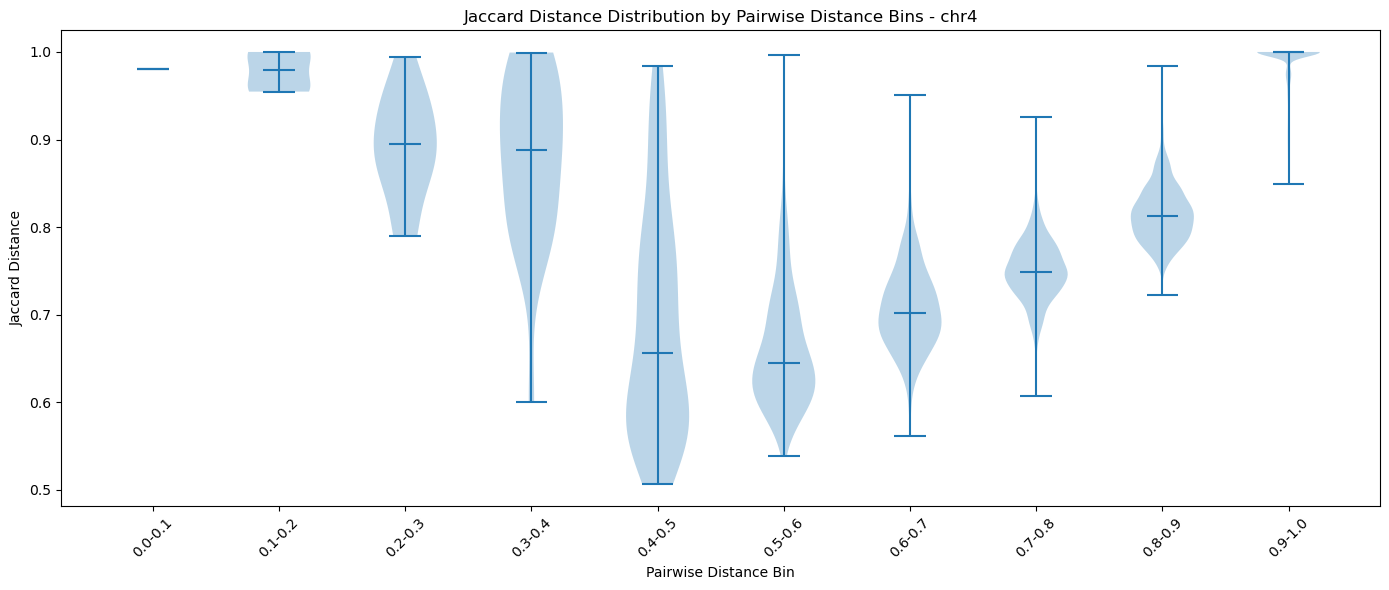

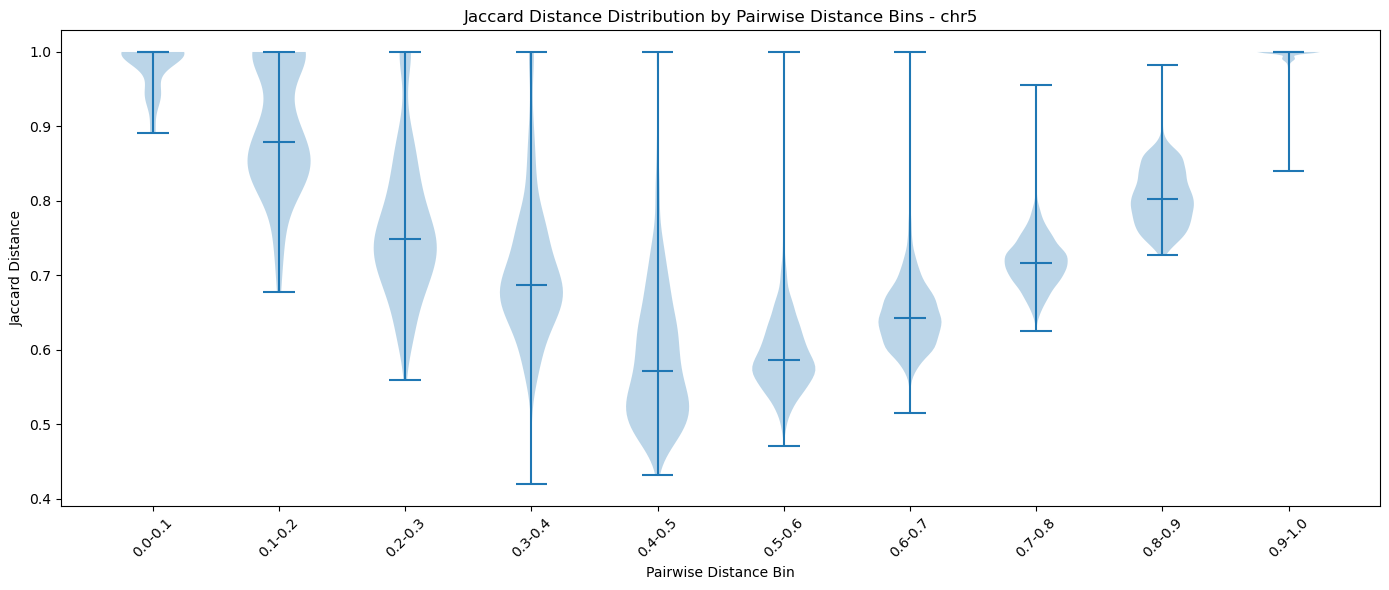

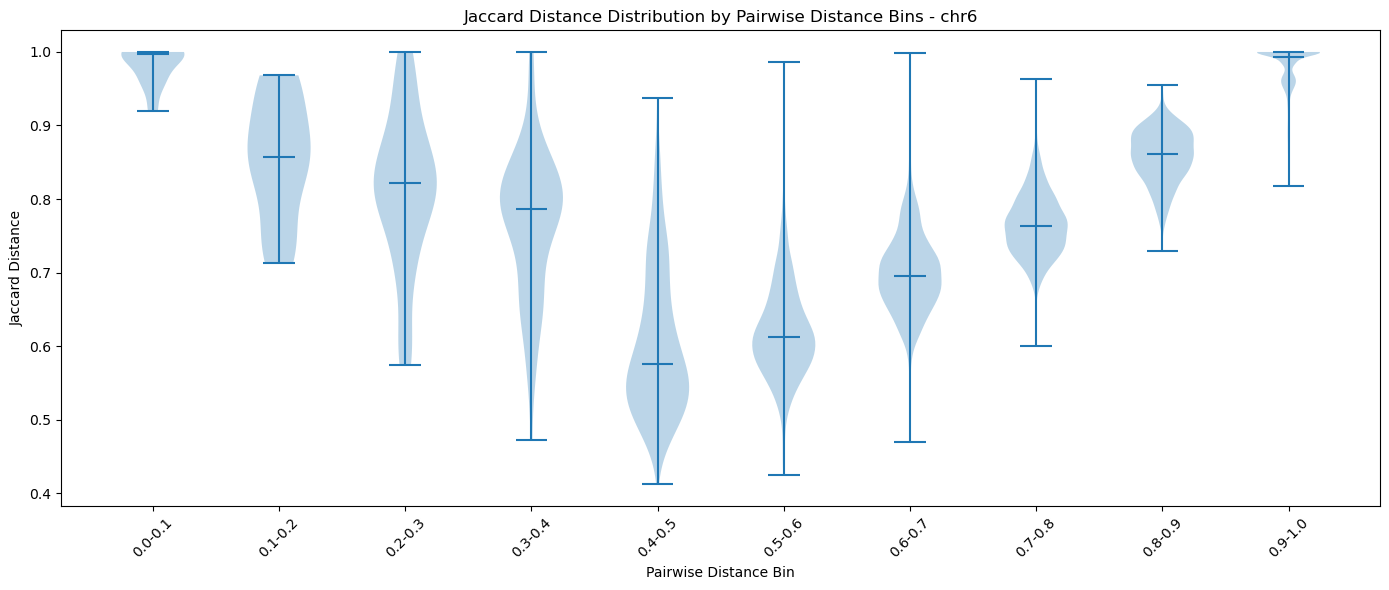

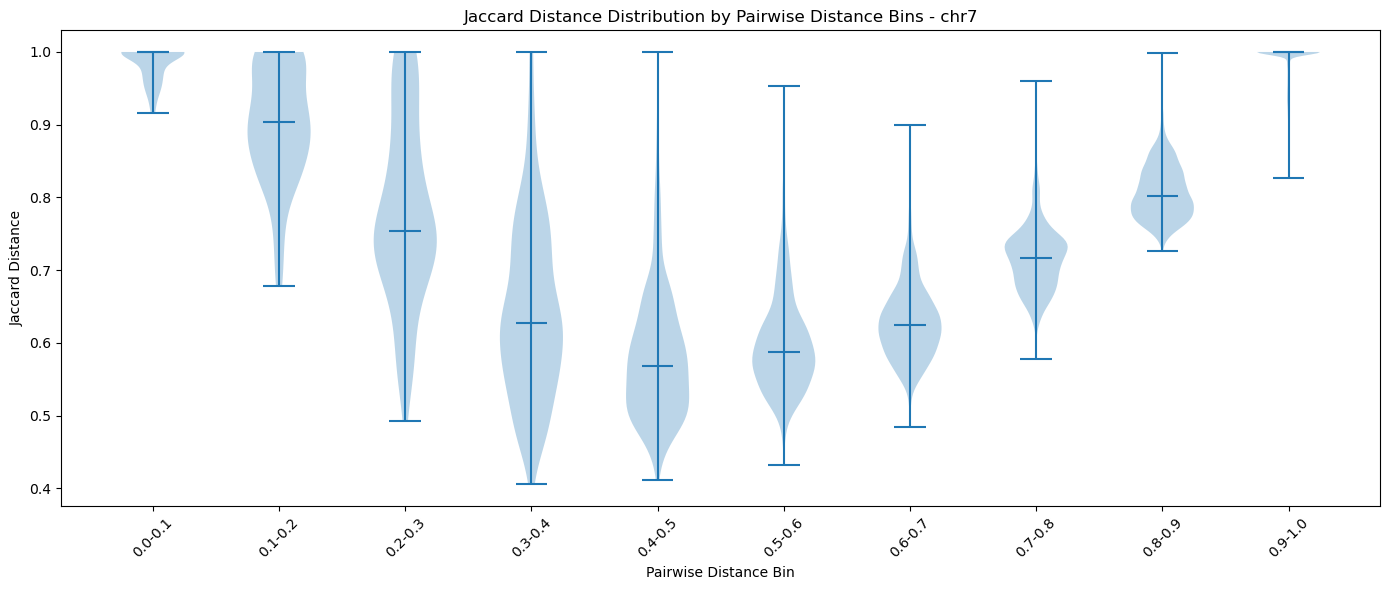

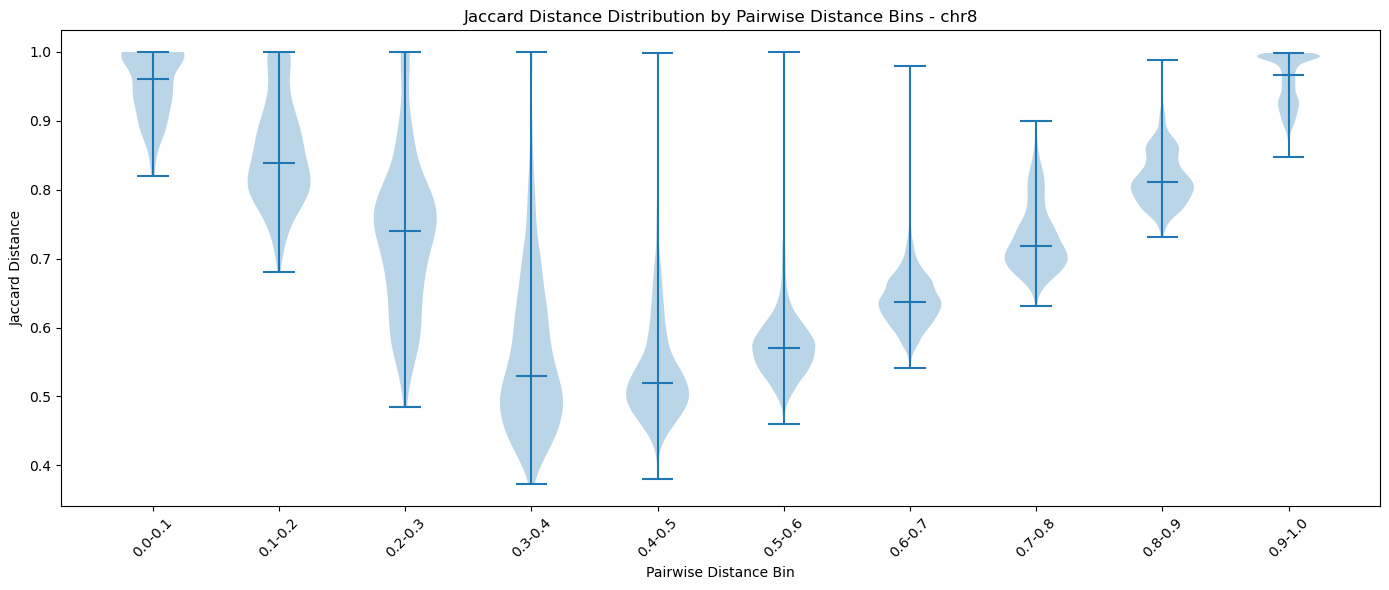

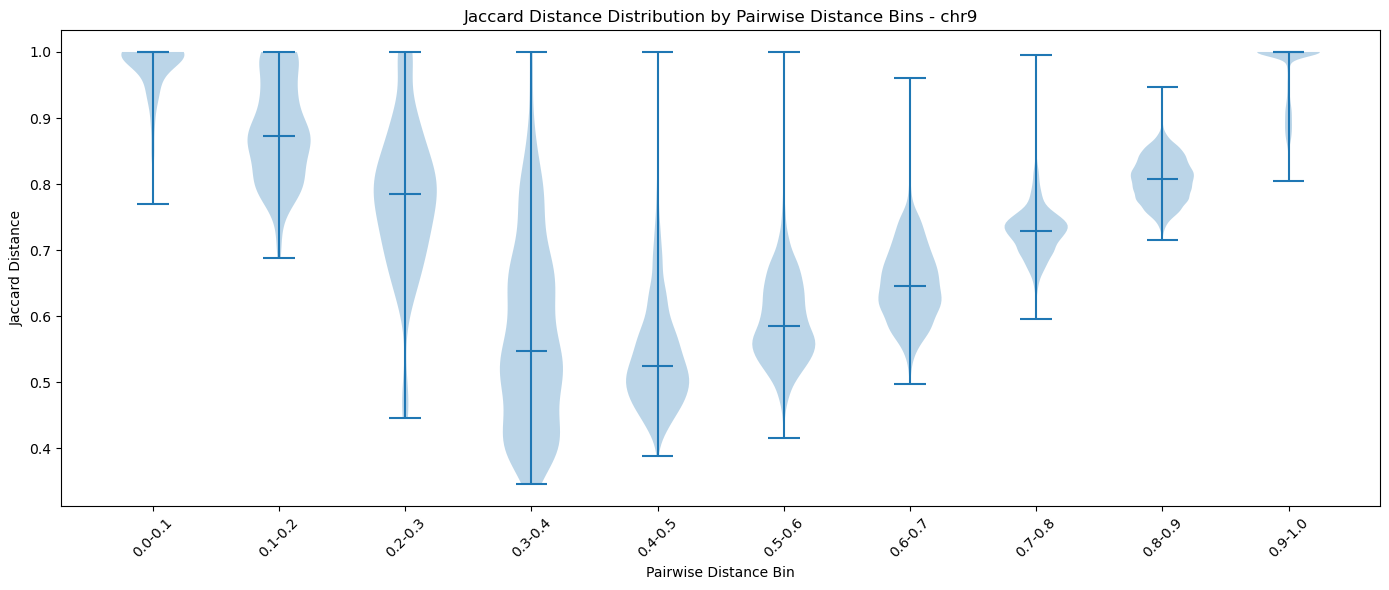

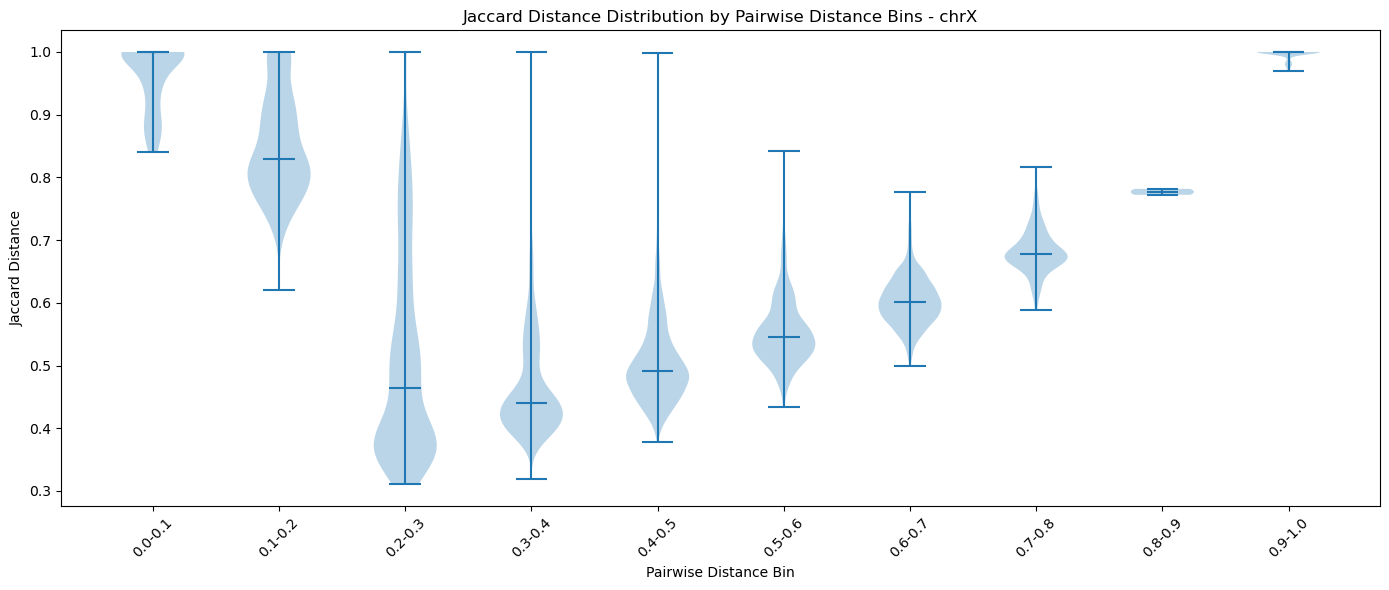

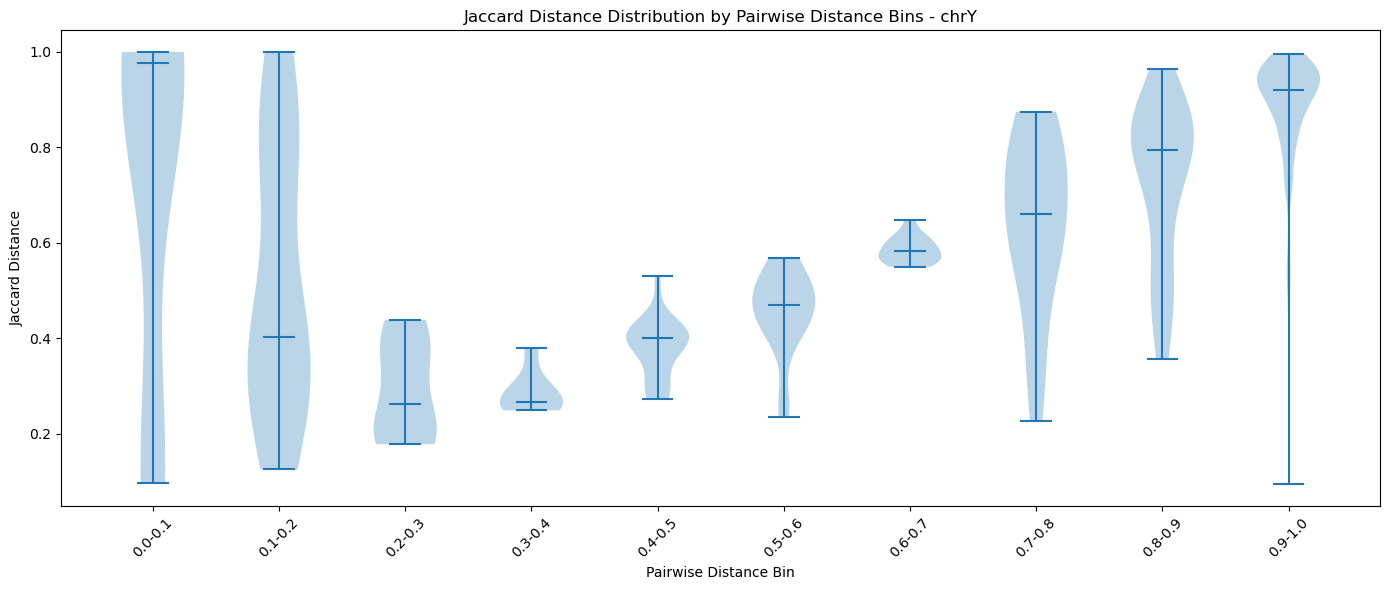

In [6]:
# Pairwise consistency histogram per chromosomes 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define bins and labels
bins = np.arange(0, 1.1, 0.1)  # 0.0, 0.1, ..., 1.0
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]

# Loop over chromosomes
for chrom in sorted(df["chr"].unique()):
    df_chrom = df[df["chr"] == chrom].copy()
    
    # Bin pairwise distances
    df_chrom["dist_bin"] = pd.cut(df_chrom["pairwise_dist"], bins=bins, labels=labels, include_lowest=True)
    
    # Prepare data for violin plot
    groups = [
        df_chrom.loc[df_chrom["dist_bin"] == label, "jaccard"].dropna().values
        for label in labels
    ]
    
    plt.figure(figsize=(14, 6))
    plt.violinplot(groups, showmeans=False, showmedians=True, showextrema=True)
    
    plt.xticks(range(1, len(labels) + 1), labels, rotation=45)
    plt.ylabel("Jaccard Distance")
    plt.xlabel("Pairwise Distance Bin")
    plt.title(f"Jaccard Distance Distribution by Pairwise Distance Bins - {chrom}")
    
    plt.tight_layout()
    plt.show()


### Per chrom results just for pairwise dist < 0.2 

/data/tmp/ipykernel_943928/398116369.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub["chr"] = df_sub["chr"].astype(str)
/data/tmp/ipykernel_943928/398116369.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/data/tmp/ipykernel_943928/398116369.py:22: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


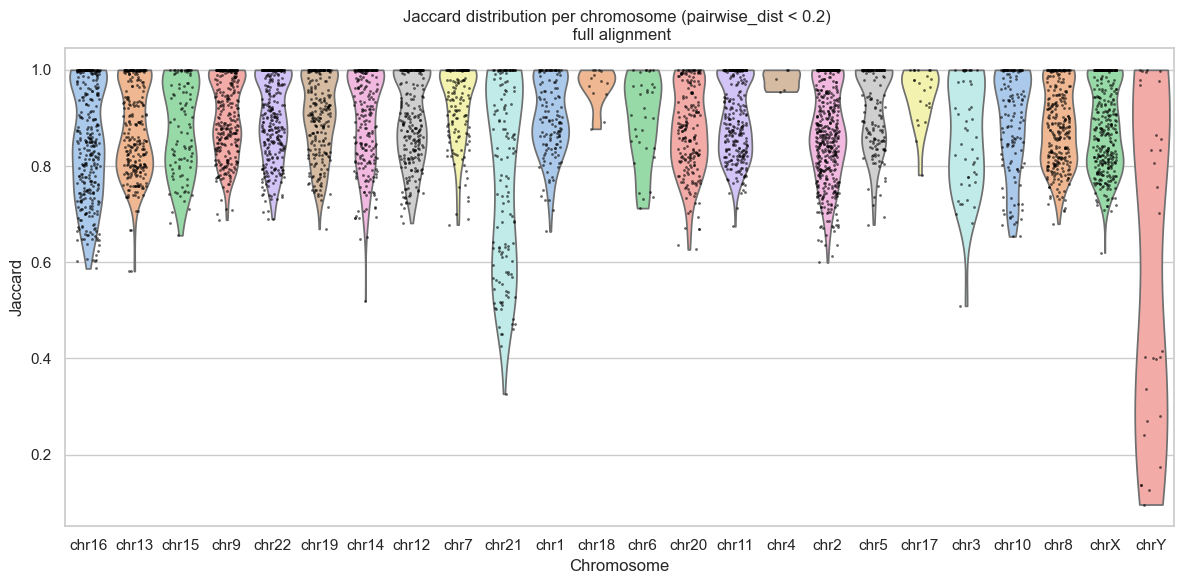

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# subset dataframe
df_sub = df[df["pairwise_dist"] < 0.2]

# make sure chr is categorical
df_sub["chr"] = df_sub["chr"].astype(str)

# set style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# palette (one color per chromosome)
chrs = df_sub["chr"].unique()
palette = sns.color_palette("pastel", n_colors=len(chrs))
palette_dict = dict(zip(chrs, palette))

# violin plot
sns.violinplot(
    data=df_sub,
    x="chr",
    y="jaccard",
    inner=None,
    cut=0,
    scale="width",
    palette=palette_dict
)

# strip plot overlay
sns.stripplot(
    data=df_sub,
    x="chr",
    y="jaccard",
    color="black",
    jitter=0.25,
    size=2,
    alpha=0.6
)

plt.xlabel("Chromosome")
plt.ylabel("Jaccard")
plt.title("Jaccard distribution per chromosome (pairwise_dist < 0.2) \n full alignment")
plt.tight_layout()
plt.show()


In [19]:
print(df_sub["chr"].unique()[:10])


[NaN]
Categories (22, object): ['1' < '2' < '3' < '4' ... '19' < '20' < '21' < '22']


/data/tmp/ipykernel_943928/3905816721.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/data/tmp/ipykernel_943928/3905816721.py:34: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


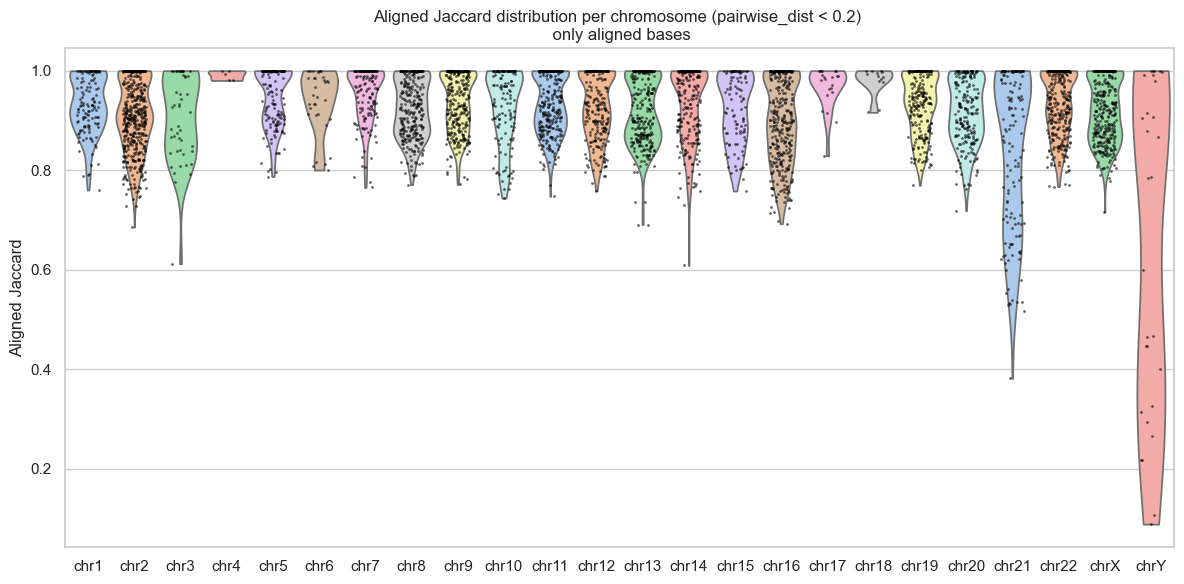

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# subset dataframe
df_sub = df[df["pairwise_dist"] < 0.2].copy()

# keep original 'chr' strings
df_sub["chr"] = df_sub["chr"].astype(str)  # e.g., 'chr1', 'chrX', etc.

# build correct order
# extract numeric part for autosomes
autos = sorted(
    [c for c in df_sub["chr"].unique() if c[3:].isdigit()],
    key=lambda x: int(x[3:])
)
# add sex chromosomes if present
sex = [c for c in ["chrX", "chrY"] if c in df_sub["chr"].values]

chr_order = autos + sex

# make chr an ordered categorical (preserves 'chr' prefix in labels)
df_sub["chr"] = pd.Categorical(df_sub["chr"], categories=chr_order, ordered=True)

# style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# pastel palette
palette = sns.color_palette("pastel", len(chr_order))
palette_dict = dict(zip(chr_order, palette))

# violin plot
sns.violinplot(
    data=df_sub,
    x="chr",
    y="aligned_jaccard",
    inner=None,
    cut=0,
    scale="width",
    palette=palette_dict
)

# strip plot overlay
sns.stripplot(
    data=df_sub,
    x="chr",
    y="aligned_jaccard",
    color="black",
    jitter=0.25,
    size=2,
    alpha=0.6
)

plt.ylabel("Aligned Jaccard")
plt.xlabel("")  # removes x-axis title
plt.title("Aligned Jaccard distribution per chromosome (pairwise_dist < 0.2) \n only aligned bases")
plt.tight_layout()
plt.show()




In [5]:
# First subset to pairwise_dist < 0.2
df_sub = df[df["pairwise_dist"] < 0.2]

# Then filter for chrY
df_chrY = df_sub[df_sub["chr"] == "chrY"]

# Sort by jaccard and show the lowest values
lowest_jaccard = df_chrY.nsmallest(10, "jaccard")
print(lowest_jaccard)

# Or if you want just the absolute minimum:
min_jaccard = df_chrY.nsmallest(1, "jaccard")
print(f"\nLowest jaccard value for chrY (pairwise_dist < 0.2):")
print(min_jaccard)

# See summary stats
print(f"\nNumber of chrY pairs with pairwise_dist < 0.2: {len(df_chrY)}")
print(f"Min jaccard: {df_chrY['jaccard'].min():.4f}")
print(f"Max jaccard: {df_chrY['jaccard'].max():.4f}")
print(f"Mean jaccard: {df_chrY['jaccard'].mean():.4f}")


          sample1    sample2  intersection   union  aligned_intersection  \
469567  HG00621.1  HG01358.1         67185  697123                 30633   
470046  HG02391.1  NA20752.1        106604  849232                 33778   
469406    CHM13.0  HG02391.1         96013  701518                 69221   
469491    HG002.1  HG02391.1         96013  701518                 69222   
470040  HG02391.1  NA18945.1        119168  685569                 98917   
469400    CHM13.0  HG01261.1        141765  588140                106283   
469559  HG00621.1  HG00642.1        171117  635849                121310   
469485    HG002.1  HG01261.1        159698  570207                124217   
470304  NA18952.1  NA19043.1         85425  253900                 54292   
469486    HG002.1  HG01358.1        209569  524713                162793   

        aligned_union   jaccard  aligned_jaccard  num_pos_ind  num_pos_dir  \
469567         343719  0.096375         0.089122       457653       306655   
470046 

### Scatterplot of induced pairwise versus direct pairwise 

In [22]:
# Read in direct pairwise dist values 

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df["sample_pair"] = (
    all_pairs_dist_df[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr,sample_pair
0,HG03098.1,HG03784.1,0.942968,chr6,HG03098.1_HG03784.1
1,HG03098.1,NA20752.2,0.974936,chr6,HG03098.1_NA20752.2
2,HG01978.2,NA19835.1,0.999883,chr6,HG01978.2_NA19835.1
3,HG00741.1,NA18522.1,0.999869,chr6,HG00741.1_NA18522.1
4,HG00408.1,HG01496.1,0.606856,chr6,HG00408.1_HG01496.1


In [23]:
# Read in induced pairwise distance values
induced_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/MSA/induced_pairwise_distances/"

# Glob for all matching CSVs across chr subdirectories
induced_files = glob.glob(os.path.join(induced_dist_dir, "*/*_r2_QC_v2_centrolign_induced_pairwise_distance.csv"))

all_induced_dfs = []

for f in induced_files:
    # Extract chr from parent directory name
    chr_val = os.path.basename(os.path.dirname(f))

    df_ind = pd.read_csv(f, header=None, names=['sample1', 'sample2', 'induced_pairwise_dist'])
    df_ind["chr"] = chr_val

    all_induced_dfs.append(df_ind)

# Combine into one dataframe
induced_dist_df = pd.concat(all_induced_dfs, ignore_index=True)

induced_dist_df["sample_pair"] = (
    induced_dist_df[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

induced_dist_df.head()


,sample1,sample2,induced_pairwise_dist,chr,sample_pair
0,HG00609.1,NA18967.1,0.764351,chr11,HG00609.1_NA18967.1
1,HG01071.1,HG02572.2,0.999990,chr11,HG01071.1_HG02572.2
2,NA21093.2,HG01109.1,0.949435,chr11,HG01109.1_NA21093.2
3,NA19043.1,HG01099.2,0.839182,chr11,HG01099.2_NA19043.1
4,HG01993.2,HG03050.2,0.999992,chr11,HG01993.2_HG03050.2


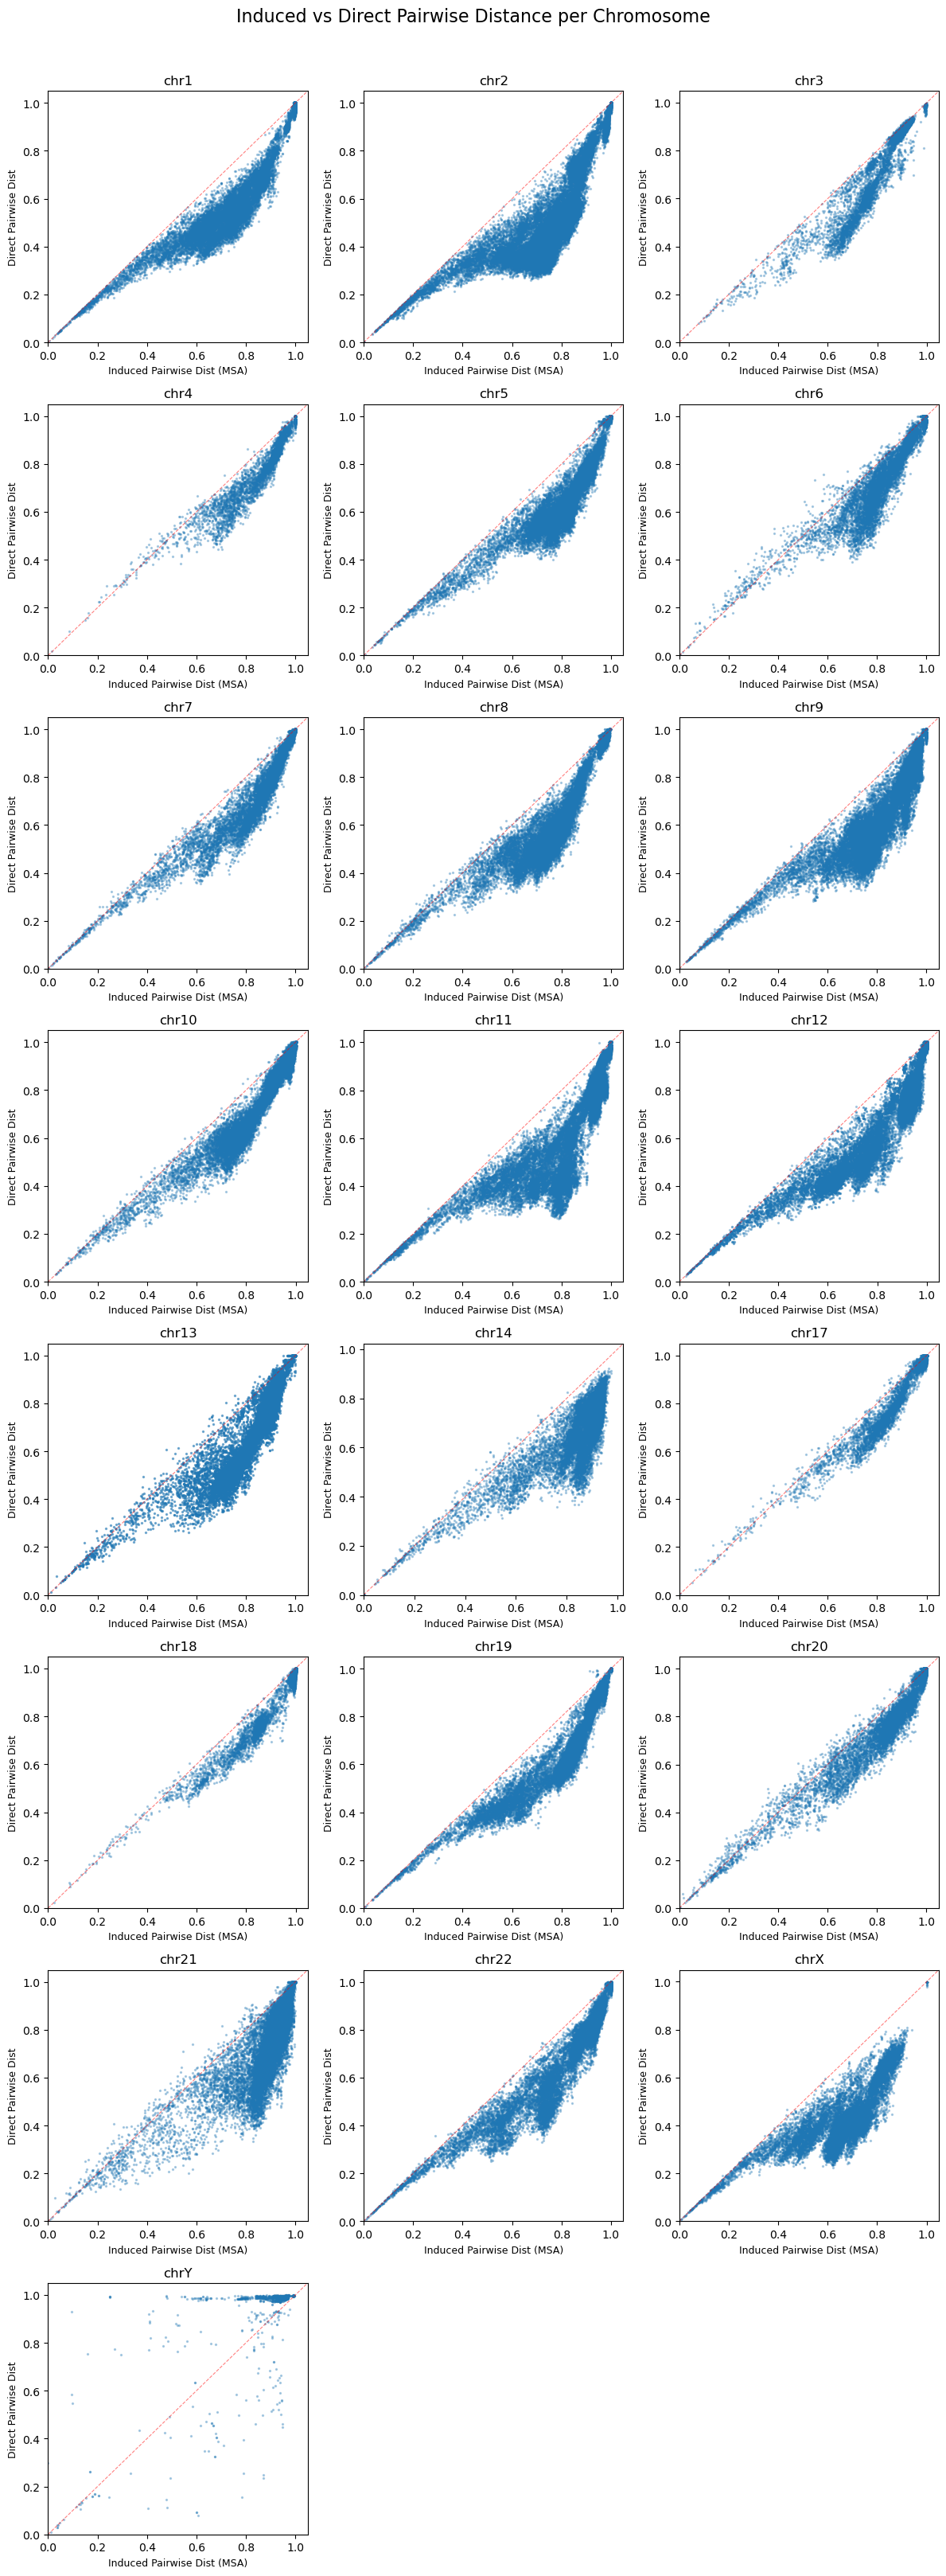

In [25]:
# Merge induced and direct pairwise distances using sample_pair key
df_compare = induced_dist_df.merge(
    all_pairs_dist_df,
    on=['sample_pair', 'chr'],
    how='left'
)

# Build chromosome order
chroms = df_compare["chr"].unique()
autos = sorted([c for c in chroms if c[3:].isdigit()], key=lambda x: int(x[3:]))
sex = [c for c in ["chrX", "chrY"] if c in chroms]
chr_order = autos + sex

# Set up subplots
n_chroms = len(chr_order)
ncols = 3
nrows = int(np.ceil(n_chroms / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axes = axes.flatten()

for i, chrom in enumerate(chr_order):
    ax = axes[i]
    df_chr = df_compare[df_compare["chr"] == chrom]
    ax.scatter(df_chr["induced_pairwise_dist"], df_chr["direct_pairwise_dist"], s=2, alpha=0.3)
    # Plot y=x line
    lims = [0, max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, 'r--', linewidth=0.8, alpha=0.5)
    ax.set_title(chrom)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel("Induced Pairwise Dist (MSA)", fontsize=9)
    ax.set_ylabel("Direct Pairwise Dist", fontsize=9)


# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Induced vs Direct Pairwise Distance per Chromosome", fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

